### Imports 

In [1]:
import os 
import sys
import pathlib
import requests
from io import StringIO, BytesIO
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

In [3]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [4]:
import seaborn as sns

In [5]:
import numpy as np
import pandas as pd

In [6]:
from dateparser import parse

In [7]:
headers = {'User-Agent' : "Mozilla/5.0 (Macintosh; Intel Mac OS X 11_2_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.128 Safari/537.36"}

### Some parameters 

### number of months to keep (last 12)

In [8]:
n_months = 12

In [9]:
current_year = parse('this year')
current_year = current_year.strftime("%Y")

In [10]:
year = int(current_year)

In [11]:
this_month = parse('-1 months ago')
this_month = this_month.strftime("%m")

In [12]:
month = int(this_month)

In [13]:
enso_tracker_path = '../template'

In [14]:
figures_path = './figures'

In [15]:
if not pathlib.Path(figures_path).exists(): 
    pathlib.Path(figures_path).mkdir(parents=True)

In [16]:
last_valid = datetime(year, month, 1)

In [17]:
last_valid = last_valid + pd.offsets.MonthEnd(0) 

In [18]:
last_valid

Timestamp('2022-09-30 00:00:00')

In [19]:
start_date = last_valid - relativedelta(months=n_months)

In [20]:
start_date

Timestamp('2021-09-30 00:00:00')

### Access and read the NINO3.4 index from the BoM 

In [21]:
def get_BoM_NINO(nino="3.4", base_url = "http://www.bom.gov.au/climate/enso/", start_date=None, end_date=None): 
    """
    Get the NINO 3.4 index from the BoM
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    url_nino = f"{base_url}/nino_{nino}.txt"
    r = requests.get(url_nino, headers=headers)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_nino}")

    else: 
        # read the weekly NINO index, and assign the end date of the weekly period 
        nino_index = pd.read_table(BytesIO(r.content), sep=',', header=None, index_col=1, parse_dates=True, names=['iDate','SST'])

    nino_index = nino_index.resample('1M').mean()
    
    if not (start_date == end_date == None):
        nino_index = nino_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        nino_index = nino_index.loc[start_date:,:]
    
    return nino_index 

In [22]:
def get_LP_SOI(url='https://data.longpaddock.qld.gov.au/SeasonalClimateOutlook/SouthernOscillationIndex/SOIDataFiles/DailySOI1933-1992Base.txt', start_date=None, end_date=None): 
    """
    get the SOI from LongPaddock
    """
    
    from datetime import datetime, timedelta
    from dateutil.relativedelta import relativedelta
    import numpy as np 
    import pandas as pd
    
    r = requests.get(url)

    if r.status_code != 200: 
        print(f"something went wrong with accessing the URL {url_soi}")
    else: 
        soi_index = pd.read_table(BytesIO(r.content), sep='\s+', engine='python') 
        
    index = [datetime(int(year),1,1) + timedelta(int(day)-1) for year, day in soi_index.loc[:,['Year','Day']].values]
    soi_index.index = index
    soi_index = soi_index.resample('1M').mean()

    if not (start_date == end_date == None):
        soi_index = soi_index.loc[start_date:end_date,:]
    else: 
        start_date = (datetime.utcnow() - timedelta(15)) - relativedelta(months=n_months)
        soi_index = soi_index.loc[start_date:,:]
    
    return soi_index

In [23]:
def read_ENSO_categories(dpath = '../template', fname = 'Pacific_RCC_ENSO_tracker.csv'): 
    
    import pathlib
    import numpy as np 
    import pandas as pd 
    
    filename = pathlib.Path(dpath).joinpath(fname)
    
    enso_cat = pd.read_csv(filename)
    
    # goes from string to categories 
    cat_to_int = {} 

    cat_to_int['La_Nina'] = -3
    cat_to_int['La_Nina_alert'] = -2
    cat_to_int['La_Nina_watch'] = -1
    cat_to_int['neutral'] = 0
    cat_to_int['El_Nino_watch'] = 1 
    cat_to_int['El_Nino_alert'] = 2 
    cat_to_int['El_Nino'] = 3
    
    enso_cat_int = enso_cat.replace(cat_to_int)
    
    enso_cat_int.loc[:,'date'] = np.NaN
    
    # build the index 
    enso_cat_int.loc[:,'date'] = enso_cat_int.loc[:,'YEAR'].astype(str) + "-" + enso_cat_int.loc[:,'MONTH'].astype(str).str.zfill(2)
    
    enso_cat_int = enso_cat_int.set_index('date').drop(['YEAR','MONTH'],axis=1) 
    
    enso_cat_int.index = pd.to_datetime(enso_cat_int.index) + pd.offsets.MonthEnd(0) 
    
    return enso_cat_int

In [24]:
nino_index = get_BoM_NINO(start_date=start_date, end_date=last_valid)

In [25]:
nino_index

,iDate,SST
2021-09-30,20210892.25,-0.2275
2021-10-31,20210997.00,-0.5940
2021-11-30,20211111.50,-0.5925
2021-12-31,20211192.00,-0.6750
2022-01-31,20218336.20,-0.7040
2022-02-28,20220193.25,-0.6000
2022-03-31,20220292.50,-0.7900
2022-04-30,20220390.25,-0.6575
2022-05-31,20220495.00,-0.7120
2022-06-30,20220592.25,-0.4050


In [26]:
soi_index = get_LP_SOI(start_date=start_date, end_date=last_valid)

In [27]:
soi_index

,Year,Day,Tahiti,Darwin,SOI
2021-09-30,2021.0,258.5,1015.874667,1012.006667,9.073333
2021-10-31,2021.0,289.0,1013.696129,1009.679032,6.767419
2021-11-30,2021.0,319.5,1013.078000,1008.296667,12.344000
2021-12-31,2021.0,350.0,1012.708065,1006.500000,13.885806
2022-01-31,2022.0,16.0,1011.787419,1006.541935,3.883226
2022-02-28,2022.0,45.5,1013.175000,1006.939286,7.883214
2022-03-31,2022.0,75.0,1014.101613,1007.533871,14.335806
2022-04-30,2022.0,105.5,1013.606333,1008.498333,22.660667
2022-05-31,2022.0,136.0,1014.328710,1010.430645,17.835806
2022-06-30,2022.0,166.5,1015.407000,1011.725000,20.259333


### check 

In [28]:
if len(soi_index) != len(nino_index): 
    print(f"check the SOI and NINO3.4 index data, the SOI Index has length {len(soi_index)} and the NINO Index has length {len(nino_index)}")

### merge the NINO and SOI index 

In [29]:
ENSO_index = pd.concat([nino_index, soi_index], axis=1)

In [30]:
ENSO_index = ENSO_index.dropna()

In [31]:
ENSO_index.head()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2021-09-30,20210892.25,-0.2275,2021.0,258.5,1015.874667,1012.006667,9.073333
2021-10-31,20210997.00,-0.5940,2021.0,289.0,1013.696129,1009.679032,6.767419
2021-11-30,20211111.50,-0.5925,2021.0,319.5,1013.078000,1008.296667,12.344000
2021-12-31,20211192.00,-0.6750,2021.0,350.0,1012.708065,1006.500000,13.885806
2022-01-31,20218336.20,-0.7040,2022.0,16.0,1011.787419,1006.541935,3.883226


In [32]:
ENSO_index.tail()

,iDate,SST,Year,Day,Tahiti,Darwin,SOI
2022-05-31,20220495.00,-0.7120,2022.0,136.0,1014.328710,1010.430645,17.835806
2022-06-30,20220592.25,-0.4050,2022.0,166.5,1015.407000,1011.725000,20.259333
2022-07-31,20220697.00,-0.3380,2022.0,197.0,1015.364839,1013.148387,8.191290
2022-08-31,20220811.50,-0.6650,2022.0,228.0,1015.321935,1012.222581,9.115161
2022-09-30,20220891.25,-0.7575,2022.0,258.5,1016.770333,1011.320000,18.593667


### selects only the columns we actually need 

In [33]:
ENSO_index = ENSO_index.loc[:,['SST','SOI']]

### divides the SOI by 10 to get something closer to the NIWA SOI 

In [34]:
ENSO_index.loc[:,'SOI'] /= 10.

In [35]:
ENSO_index.head()

,SST,SOI
2021-09-30,-0.2275,0.907333
2021-10-31,-0.5940,0.676742
2021-11-30,-0.5925,1.234400
2021-12-31,-0.6750,1.388581
2022-01-31,-0.7040,0.388323


In [36]:
ENSO_index.tail()

,SST,SOI
2022-05-31,-0.7120,1.783581
2022-06-30,-0.4050,2.025933
2022-07-31,-0.3380,0.819129
2022-08-31,-0.6650,0.911516
2022-09-30,-0.7575,1.859367


### get the last date 

In [37]:
last_date = pd.to_datetime(ENSO_index.index[-1])

In [38]:
last_date

Timestamp('2022-09-30 00:00:00', freq='M')

### get the values and the basis for plotting

In [39]:
soi_values = ENSO_index.SOI.values

In [40]:
nino_values = ENSO_index.SST.values 

In [41]:
basis = np.arange(len(ENSO_index))

### build the list of dates for X-axis labeling 

In [42]:
dates = ENSO_index.index.to_pydatetime()

In [43]:
dates_str = [f"{x:%b %Y}" for x in dates]

### Now read the ENSO categories from NOAA, BoM, APCC and NOAA

In [44]:
enso_cat_int = read_ENSO_categories()

In [45]:
ENSO_index.tail()

,SST,SOI
2022-05-31,-0.7120,1.783581
2022-06-30,-0.4050,2.025933
2022-07-31,-0.3380,0.819129
2022-08-31,-0.6650,0.911516
2022-09-30,-0.7575,1.859367


In [46]:
enso_cat_int.tail()

,NOAA,BoM,APCC,NIWA
date,,,,
2022-05-31,-3,-3,-3,-3
2022-06-30,-3,-1,-1,-3
2022-07-31,-3,-1,-3,-3
2022-08-31,-3,-2,-3,-3
2022-09-30,-3,-3,-3,-3


In [47]:
enso_cat_int = enso_cat_int.loc[ENSO_index.index,:]

### colors for the heatmap 

In [48]:
col_dict={-3:"#4233ff",
          -2:"#33a2ff",
          -1:"#33ffbb",
          0:"#d4d4d4",
          1:"#f3ff33", 
          2:"#ffa233",
          3:"#dc0f09"
         }

cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

In [49]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

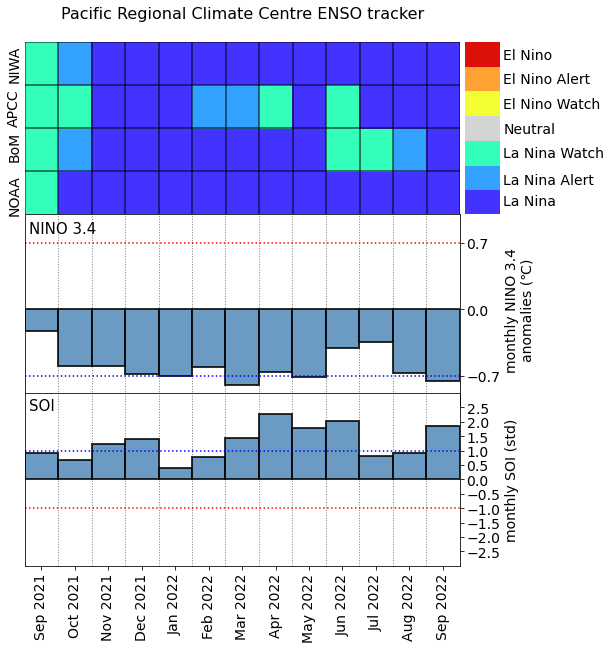

In [50]:
f = plt.figure(figsize=(8,8))

# defines the axes [left, bottom, width, height]

ax0 = f.add_axes([0.1, 0.66, 0.9, 0.3])

ax0.set_title("Pacific Regional Climate Centre ENSO tracker\n", fontsize=16)

ax1 = f.add_axes([0.1, 0.33, 0.755, 0.33])

ax2 = f.add_axes([0.1, 0.05, 0.755, 0.30])

#============================================================================================================================
# first set of axes: ENSO categories heatmap 

sns.heatmap(enso_cat_int.T, cmap=cm, center=0, vmin=-3, vmax=3, ax=ax0, \
            cbar_kws={'aspect':5, 'pad':0.01}) 

colorbar = ax0.collections[0].colorbar 

ax0.set_yticks([0.8, 1.8, 2.8, 3.8]);

ax0.set_yticklabels(['NOAA','BoM','APCC','NIWA'], fontsize=14)

ax0.set_ylim(bottom=0,top=4)

[ax0.axvline(x, color='k', lw=2, alpha=0.5) for x in range(0,len(enso_cat_int) + 1)];

[ax0.axhline(x, color='k', lw=2, alpha=0.5) for x in range(1,5)];

ax0.tick_params(direction='out', length=0, width=0)

colorbar.set_ticks([-2.5, -1.75, -0.8,  0.,  0.90, 1.75,  2.6])

colorbar.set_ticklabels(["La Nina", "La Nina Alert", "La Nina Watch", "Neutral", "El Nino Watch", "El Nino Alert", "El Nino"])    

colorbar.ax.tick_params(direction='out', length=0, width=0)

#============================================================================================================================
# second set of axes: ENSO barplot

ax1.bar(basis[nino_values>=0],nino_values[nino_values>=0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)
ax1.bar(basis[nino_values<0],nino_values[nino_values<0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)

ax1.set_xticks(basis)

ax1.set_xticklabels(dates_str, rotation=90)

ax1.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_nino = np.ceil(np.max(np.abs(nino_values)))
min_nino =- max_nino

if max_nino > 1: 
    ax1.set_ylim([min_nino, max_nino])
    ax1.set_yticks(np.arange(min_nino+0.5, max_nino, 0.5))
else: 
    ax1.set_ylim([-1, 1])
    ax1.set_yticks([-0.7, 0, 0.7])                  
    
ax1.axhline(-0.7, ls=':', color='b')
ax1.axhline(0.7, ls=':', color='r')

ax1.yaxis.tick_right()

ax1.set_ylabel('monthly NINO 3.4\nanomalies (℃)', fontsize=14)

ax1.yaxis.set_label_position("right")

[ax1.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

ax1.set_xlabel('month', fontsize=14)

ax1.text(0.01, 0.9, 'NINO 3.4', transform=ax1.transAxes, fontsize=15)

#============================================================================================================================
# second set of axes: SOI barplot

ax2.bar(basis[soi_values>=0],soi_values[soi_values>=0], width=1, facecolor='steelblue', alpha=.8, edgecolor='k', lw=2)
ax2.bar(basis[soi_values<0],soi_values[soi_values<0], width=1, facecolor='coral', alpha=.8, edgecolor='k', lw=2)

ax2.set_xticks(basis)

ax2.set_xticklabels(dates_str, rotation=90)

ax2.set_xlim([-0.5,len(dates) - 0.5])

# get the minimum and maximum values, and set limits and ticks for the y-axis accordingly 
max_soi = np.ceil(np.max(np.abs(soi_values)))
min_soi =- max_soi

if max_soi > 1.5: 
    ax2.set_ylim([min_soi, max_soi])
    ax2.set_yticks(np.arange(min_soi+0.5, max_soi, 0.5))
else: 
    ax2.set_ylim([-1.5, 1.5])
    ax2.set_yticks([-1, 0, 1])       

ax2.axhline(-1, ls=':', color='r')
ax2.axhline(1, ls=':', color='b')

ax2.yaxis.tick_right()

ax2.yaxis.set_label_position("right")

ax2.set_ylabel('monthly SOI (std)', fontsize=14)

ax2.yaxis.set_label_position("right")

ax2.text(0.01, 0.9, 'SOI', transform=ax2.transAxes, fontsize=15)

[ax2.axvline(x, color='k', lw=1, alpha=0.5, ls=':') for x in np.arange(0.5,len(dates)-0.5)];

# f.patch.set_facecolor('0.99')
f.patch.set_facecolor('w')

### saves to file 

In [51]:
f.savefig('../figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')

In [52]:
f.savefig('./figures/prototype_Pacific_RCC.png', dpi=200, bbox_inches='tight')